# **How to Train Scaled-YOLOv4 on our Pistols Dataset**

### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone Scaled_YOLOv4
!git clone https://github.com/roboflow-ai/ScaledYOLOv4.git  # clone repo
%cd /content/ScaledYOLOv4/
#checkout the yolov4-large branch
!git checkout yolov4-large

Cloning into 'ScaledYOLOv4'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 389.37 KiB | 7.49 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/ScaledYOLOv4
Branch 'yolov4-large' set up to track remote branch 'yolov4-large' from 'origin'.
Switched to a new branch 'yolov4-large'


In [ ]:
import torch
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
#install mish activation funciton for cuda
%cd /content/
!git clone https://github.com/JunnYu/mish-cuda
%cd mish-cuda
!python setup.py build install

/content
Cloning into 'mish-cuda'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 195 (delta 7), reused 79 (delta 3), pack-reused 107
Receiving objects: 100% (195/195), 208.77 KiB | 6.33 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/mish-cuda
/usr/lib/python3.7/distutils/extension.py:131: UserWarning: Unknown Extension options: 'headers'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/mish_cuda
copying src/mish_cuda/__init__.py -> build/lib.linux-x86_64-3.7/mish_cuda
running egg_info
creating src/mish_cuda.egg-info
writing src/mish_cuda.egg-info/PKG-INFO
writing dependency_links to src/mish_cuda.egg-info/dependency_links.txt
writing requirements to src/mish_cuda.egg-info/requires.txt
writing top-level names to src/mish_cuda.egg-info/top_level.txt
writing manifest file 'src/mish_cu

In [ ]:
!pip install -U PyYAML

     |████████████████████████████████| 596 kB 5.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
%cd /content/ScaledYOLOv4/


/content/ScaledYOLOv4


# Download Correctly Formatted Custom Dataset

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).



![YOLOv5 PyTorch export](https://i.imgur.com/5vr9G2u.png)


In [ ]:
# Export code snippet and paste here
%cd /content
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/pistols.zip
!unzip pistols.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/images/armas (164)_jpg.rf.18cbc212ad0d43293f498e71a625fc8c.jpg  
  inflating: train/images/armas (1640)_jpg.rf.70c28ee03c3b21a8f547340bfd38b770.jpg  
  inflating: train/images/armas (1641)_jpg.rf.b7c0c641e66196e8f51b43327e8bf985.jpg  
  inflating: train/images/armas (1642)_jpg.rf.61eb0886d7fe227d7de211687f6bc67f.jpg  
  inflating: train/images/armas (1643)_jpg.rf.9333d0dc73da3167ada3418c6cfd25cf.jpg  
  inflating: train/images/armas (1644)_jpg.rf.fbf9bfbd8a34139378307e7a2b0f702a.jpg  
  inflating: train/images/armas (1645)_jpg.rf.1cbf012a0d5106f63861289b86121b38.jpg  
  inflating: train/images/armas (1646)_jpg.rf.94d92e29a16605666276a7bb90c32ab9.jpg  
  inflating: train/images/armas (1647)_jpg.rf.42ca9b1cc4f0bdffa71fd613f0888029.jpg  
  inflating: train/images/armas (1648)_jpg.rf.cdb13fac3e5798e5e1ee32f119e5e089.jpg  
  inflating: train/images/armas (165)_jpg.rf.0b486a6a67aaaf10fa99debd0bdf6f9d.jpg  
  inflating: tra

In [ ]:
%cd /content
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

/content
train: ../train/images
val: ../valid/images

nc: 1
names: ['pistol']

#Inspect Model Configuration and Architecture

Let's look at the Scaled-YOLOv4 Configuration architecture

In [ ]:
%cat /content/ScaledYOLOv4/models/yolov4-csp.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P3/8
  - [36,75, 76,55, 72,146]  # P4/16
  - [142,110, 192,243, 459,401]  # P5/32

# yolov4-csp backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2
   [-1, 1, Bottleneck, [64]],
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4
   [-1, 2, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 5-P3/8
   [-1, 8, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 7-P4/16
   [-1, 8, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 9-P5/32
   [-1, 4, BottleneckCSP, [1024]],  # 10
  ]

# yolov4-csp head
# na = len(anchors[0])
head:
  [[-1, 1, SPPCSP, [512]], # 11
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [8, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, Bott

# Train Custom Scaled-YOLOv4 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights.
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

## **BUG in codebase, here's how to fix**

31-Mar-2022: Report - Error after first epoch

See steps to fix below:

1. Open the files panel on the right:
![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/Screenshot%202022-03-31%20at%202.16.24%20pm.png)

2. Double click on `general.py` to open in the Colab code editor:

3. Find the function `output_to_target()` located on line **1084**.

4. Copy the 2 lines of code below and insert it at line 1089 (see image blow for guidance):

```
    elif isinstance(output, list) and isinstance(output[0], torch.Tensor):  # If it's a list of torch.Tensors
      output = [item.cpu() for item in output ] # convert each one from Tensor to memory
```

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/Screenshot%202022-03-31%20at%202.16.17%20pm.png)

5. Hit CTRL+S (Windows or Linux) or CMD+S (MacOS) to save.



In [ ]:
# train scaled-YOLOv4 on custom data for 100 epochs
# time its performance
%%time
%cd /content/ScaledYOLOv4/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/yolov4-csp.yaml --weights '' --name yolov4-csp-results  --cache

/content/ScaledYOLOv4
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/yolov4-csp.yaml', data='../data.yaml', device='', epochs=100, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', img_size=[416, 416], local_rank=-1, logdir='runs/', multi_scale=False, name='yolov4-csp-results', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='', world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.5, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'm

In [ ]:
    elif isinstance(output, list) and isinstance(output[0], torch.Tensor):  # If it's a list of torch.Tensors
      output = [item.cpu() for item in output ] # convert each one from Tensor to memory


# Evaluate Custom Scaled-YOLOv4 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

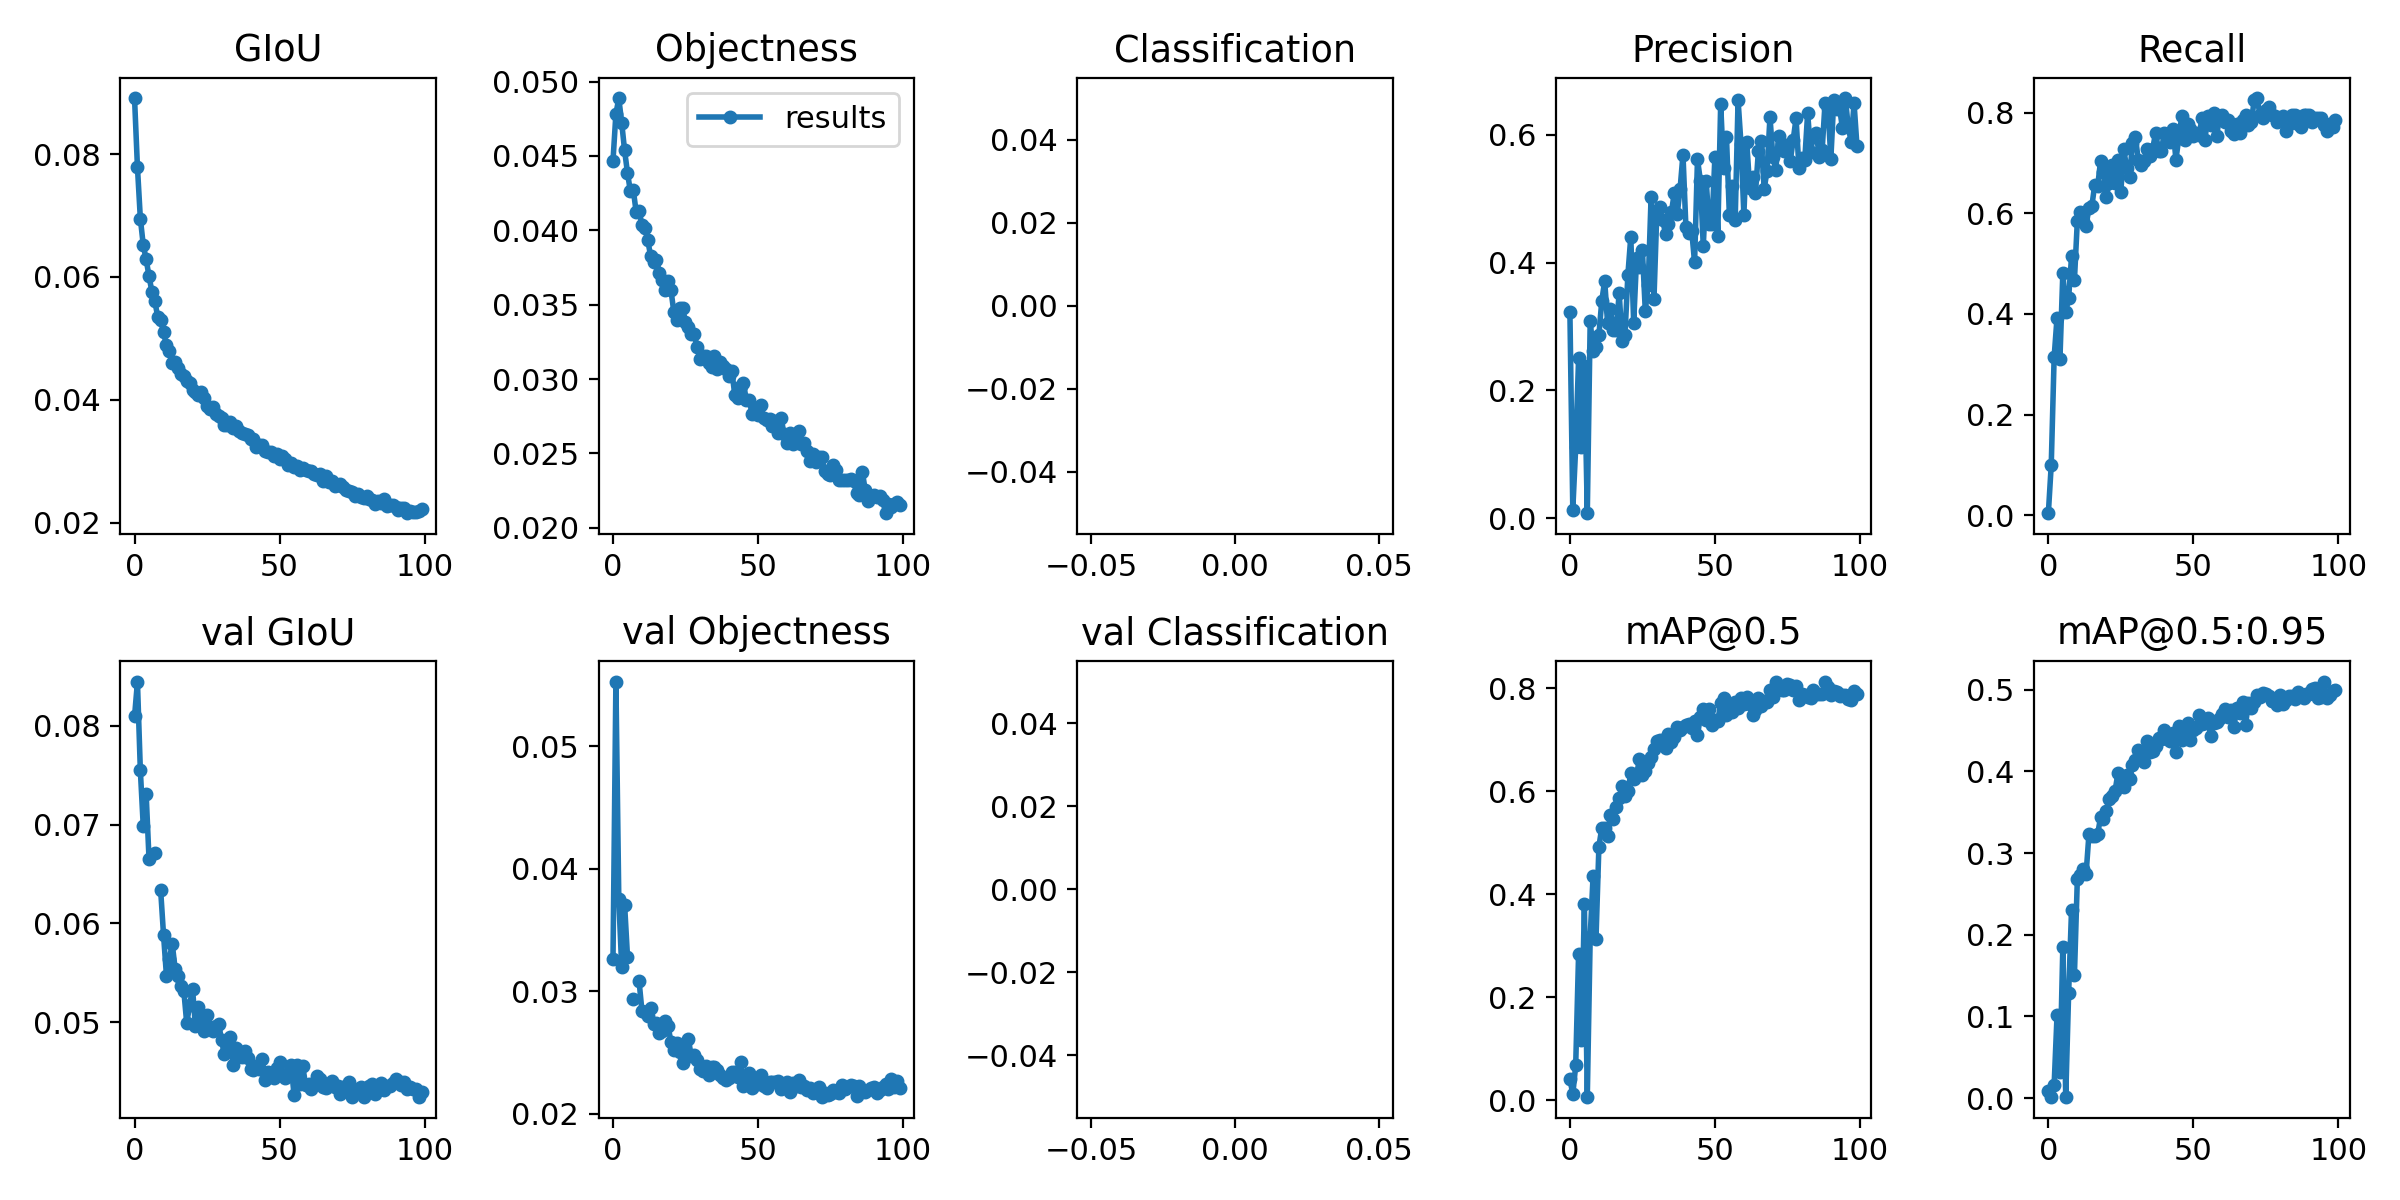

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
#from utils.general import plot_results  # plot results.txt as results.png
from IPython.display import Image, display
display(Image('/content/ScaledYOLOv4/runs/exp0_yolov4-csp-results/results.png'))  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


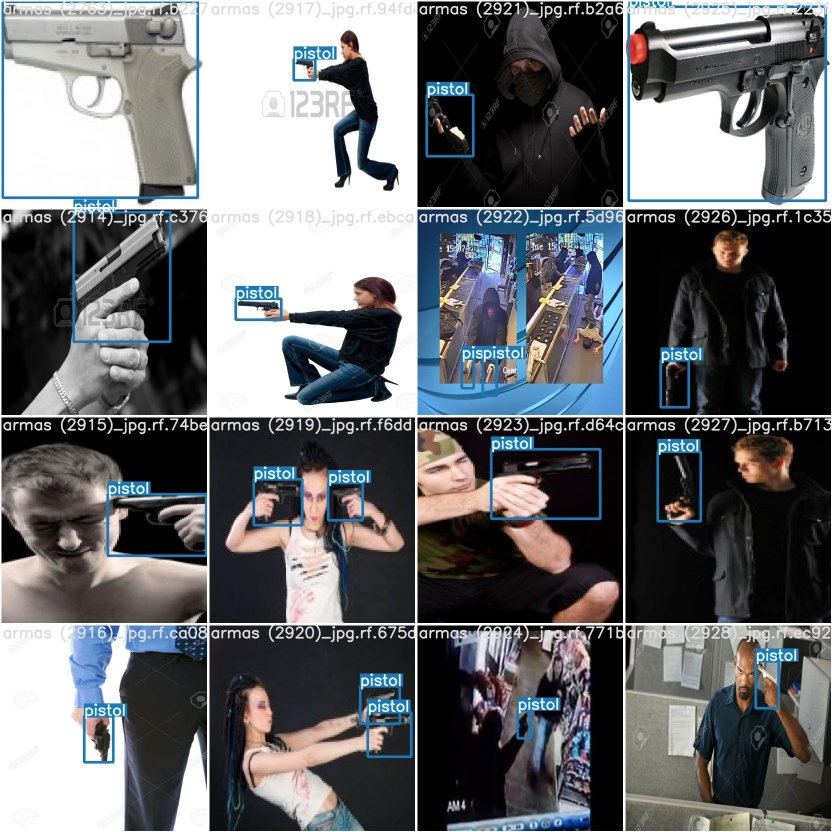

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/ScaledYOLOv4/runs/exp0_yolov4-csp-results/test_batch0_gt.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


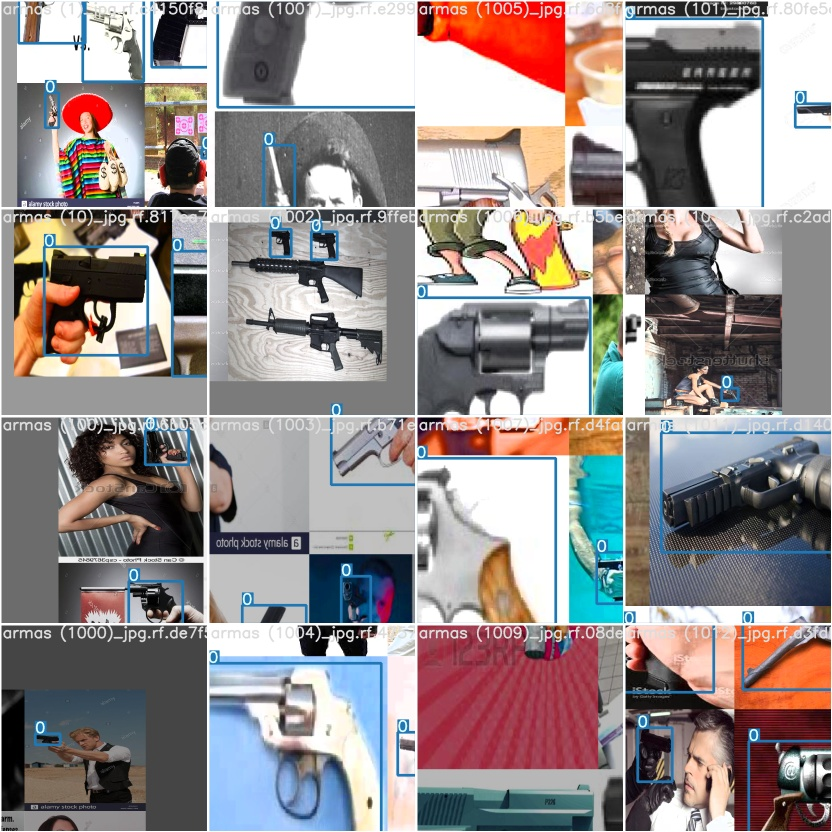

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/ScaledYOLOv4/runs/exp0_yolov4-csp-results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

exp0_yolov4-csp-results/


In [ ]:
%ls ./runs/exp0_yolov4-csp-results/weights

best_yolov4-csp-results.pt        last_080.pt  last_092.pt
best_yolov4-csp-results_strip.pt  last_081.pt  last_093.pt
last_070.pt                       last_082.pt  last_094.pt
last_071.pt                       last_083.pt  last_095.pt
last_072.pt                       last_084.pt  last_096.pt
last_073.pt                       last_085.pt  last_097.pt
last_074.pt                       last_086.pt  last_098.pt
last_075.pt                       last_087.pt  last_099.pt
last_076.pt                       last_088.pt  last_yolov4-csp-results.pt
last_077.pt                       last_089.pt  last_yolov4-csp-results_strip.pt
last_078.pt                       last_090.pt
last_079.pt                       last_091.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/ScaledYOLOv4/
!python detect.py --weights ./runs/exp0_yolov4-csp-results/weights/best_yolov4-csp-results.pt --img 416 --conf 0.4 --source ../test/images

/content/ScaledYOLOv4
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='../test/images', update=False, view_img=False, weights=['./runs/exp0_yolov4-csp-results/weights/best_yolov4-csp-results.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... Model Summary: 235 layers, 5.24706e+07 parameters, 5.04494e+07 gradients
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
image 1/119 /content/test/images/armas (2644)_jpg.rf.c334b68d1fa221dcab1d93c8773795be.jpg: 416x416 

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above
import glob
from IPython.display import Image, display

for imageName in glob.glob('./inference/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import files
files.download('./runs/exp0_yolov4-csp-results/weights/best_yolov4-csp-results.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>